In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [25]:
EPOCHS = 100
INIT_LR = 3e-3
BS =32
default_image_size = tuple((256, 256))
image_size = 0
width=256
height=256
depth=3
train_dir=r"C:\Users\Glau\Desktop\cancer_cell\single_fifteen"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
callbacks = MyCustomCallback()

In [8]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".tiff") == True or image_directory.endswith(".TIFF") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing BAS ...
processing EBO ...
processing EOS ...
processing KSC ...
processing LYA ...
processing LYT ...
processing MMZ ...
processing MOB ...
processing MON ...
processing MYB ...
processing MYO ...
processing NGB ...
processing NGS ...
processing PMB ...
processing PMO ...
[INFO] Image loading completed


In [9]:
print(len(train_image_label))

18365


In [10]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_cancer_cell_new.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [11]:
print(len(bin_train_image_labels))

18365


In [12]:
print(len(bin_train_image_labels))

18365


In [13]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [14]:
print(len(np_train_image_list))

18365


In [1]:
from tensorflow.keras import models

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras import layers
#
# image dimensions
#

img_height = 256
img_width = 256
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.ReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(15,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 3232        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

conv2d_428 (Conv2D)             (None, 16, 16, 8)    584         lambda_399[0][0]                 
__________________________________________________________________________________________________
conv2d_429 (Conv2D)             (None, 16, 16, 8)    584         lambda_400[0][0]                 
__________________________________________________________________________________________________
conv2d_430 (Conv2D)             (None, 16, 16, 8)    584         lambda_401[0][0]                 
__________________________________________________________________________________________________
conv2d_431 (Conv2D)             (None, 16, 16, 8)    584         lambda_402[0][0]                 
__________________________________________________________________________________________________
conv2d_432 (Conv2D)             (None, 16, 16, 8)    584         lambda_403[0][0]                 
__________________________________________________________________________________________________
conv2d_433

Total params: 18,358,575
Trainable params: 18,302,959
Non-trainable params: 55,616
__________________________________________________________________________________________________
None


In [2]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

NameError: name 'Adam' is not defined

In [27]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [29]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val = bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)

Train on 14692 samples, validate on 3673 samples
Epoch 1/100
14692/14692 [==============================] - 265s 18ms/sample - loss: 0.4591 - accuracy: 0.8727 - val_loss: 10.6509 - val_accuracy: 0.5067
Epoch 2/100
14692/14692 [==============================] - 223s 15ms/sample - loss: 0.3795 - accuracy: 0.8980 - val_loss: 0.7129 - val_accuracy: 0.8189
Epoch 3/100
14692/14692 [==============================] - 222s 15ms/sample - loss: 0.3106 - accuracy: 0.9130 - val_loss: 0.9599 - val_accuracy: 0.7122
Epoch 4/100
14692/14692 [==============================] - 222s 15ms/sample - loss: 0.2849 - accuracy: 0.9217 - val_loss: 2.2670 - val_accuracy: 0.6188
Epoch 5/100
14692/14692 [==============================] - 221s 15ms/sample - loss: 0.2515 - accuracy: 0.9286 - val_loss: 4.1090 - val_accuracy: 0.4370
Epoch 6/100
14692/14692 [==============================] - 222s 15ms/sample - loss: 0.2410 - accuracy: 0.9300 - val_loss: 0.2785 - val_accuracy: 0.9347
Epoch 7/100
14692/14692 [=============

14692/14692 [==============================] - 223s 15ms/sample - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.0124 - val_accuracy: 0.9948
Epoch 8/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.0116 - val_accuracy: 0.9970
Epoch 9/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0465 - val_accuracy: 0.9839
Epoch 10/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0273 - val_accuracy: 0.9902
Epoch 11/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0101 - val_accuracy: 0.9967
Epoch 12/100
14692/14692 [==============================] - 221s 15ms/sample - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0726 - val_accuracy: 0.9812
Epoch 13/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 0.0034 - acc

14692/14692 [==============================] - 219s 15ms/sample - loss: 9.7338e-04 - accuracy: 0.9998 - val_loss: 4.8106e-04 - val_accuracy: 1.0000
Epoch 13/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 1.2586e-04 - accuracy: 1.0000 - val_loss: 5.0238e-05 - val_accuracy: 1.0000
Epoch 14/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 4.5016e-04 - accuracy: 0.9998 - val_loss: 8.5648e-04 - val_accuracy: 0.9997
Epoch 15/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0041 - val_accuracy: 0.9984
Epoch 16/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 3.6312e-04 - accuracy: 0.9999 - val_loss: 5.7250e-05 - val_accuracy: 1.0000
Epoch 17/100
14692/14692 [==============================] - 220s 15ms/sample - loss: 6.6839e-05 - accuracy: 1.0000 - val_loss: 3.4231e-05 - val_accuracy: 1.0000
Epoch 18/100
14692/14692 [=============================

14692/14692 [==============================] - 214s 15ms/sample - loss: 2.0144e-04 - accuracy: 1.0000 - val_loss: 3.4459e-04 - val_accuracy: 0.9997
Epoch 15/100
14692/14692 [==============================] - 215s 15ms/sample - loss: 7.3262e-04 - accuracy: 0.9997 - val_loss: 4.2864e-04 - val_accuracy: 0.9997
Epoch 16/100
14692/14692 [==============================] - 215s 15ms/sample - loss: 0.0020 - accuracy: 0.9995 - val_loss: 5.8227e-05 - val_accuracy: 1.0000
Epoch 17/100
14692/14692 [==============================] - 216s 15ms/sample - loss: 5.4065e-04 - accuracy: 0.9999 - val_loss: 1.3024e-04 - val_accuracy: 1.0000
Epoch 18/100
14692/14692 [==============================] - 215s 15ms/sample - loss: 5.1228e-05 - accuracy: 1.0000 - val_loss: 4.0307e-05 - val_accuracy: 1.0000
Epoch 19/100
14692/14692 [==============================] - 216s 15ms/sample - loss: 2.5035e-04 - accuracy: 0.9998 - val_loss: 6.8529e-05 - val_accuracy: 1.0000
Epoch 20/100
14692/14692 [=========================

14692/14692 [==============================] - 216s 15ms/sample - loss: 5.1781e-06 - accuracy: 1.0000 - val_loss: 1.5804e-06 - val_accuracy: 1.0000
Epoch 17/100
14692/14692 [==============================] - 216s 15ms/sample - loss: 4.7826e-06 - accuracy: 1.0000 - val_loss: 1.3295e-06 - val_accuracy: 1.0000
Epoch 18/100
14692/14692 [==============================] - 216s 15ms/sample - loss: 3.7847e-06 - accuracy: 1.0000 - val_loss: 1.1032e-06 - val_accuracy: 1.0000
Epoch 19/100
14692/14692 [==============================] - 217s 15ms/sample - loss: 5.4369e-06 - accuracy: 1.0000 - val_loss: 1.0481e-06 - val_accuracy: 1.0000
Epoch 20/100
14692/14692 [==============================] - 219s 15ms/sample - loss: 2.0835e-05 - accuracy: 1.0000 - val_loss: 1.7716e-04 - val_accuracy: 1.0000
Epoch 21/100
14692/14692 [==============================] - 218s 15ms/sample - loss: 6.0430e-06 - accuracy: 1.0000 - val_loss: 1.6100e-06 - val_accuracy: 1.0000
Epoch 22/100
14692/14692 [=====================

In [37]:
for i in range(0,5):
    print(conf_matrix_list_of_arrays[0])
#print(cm)

[[   2    0    0    0    0    0    2    0    0    0    3    0    5    0
     0]
 [   0    8    0    0    0    3    0    0    1    0    0    0    0    0
     0]
 [   2    0   77    0    0    0    0    0    0    0    1    1    2    0
     0]
 [   0    0    0    1    0    0    0    0    0    0    0    0    1    0
     0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    1    4    0    1  716    2    0   12    3   52    1    3    0
     0]
 [   0    0    0    0    0    2    0    0    0    1    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    4    0    2    0    0    0
     0]
 [   1    0    1    0    0    4    2    0  266   17   43    1    6    0
    18]
 [   0    0    0    0    0    0    1    0    0    0    1    0    0    0
     2]
 [   0    0    1    0    0    4    0    0    8    4  594    0    0    1
    18]
 [   0    0    0    0    0    0    1    0    2    0    0    0   20    0
     0]
 [   4    0    8    0    0    4    0    

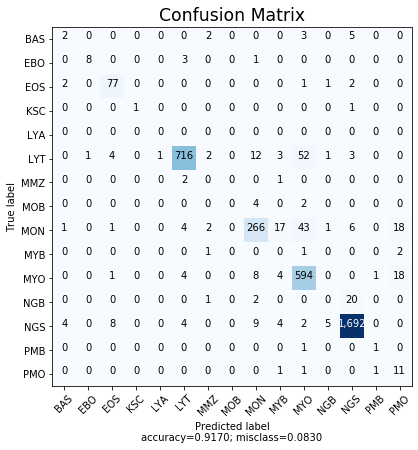

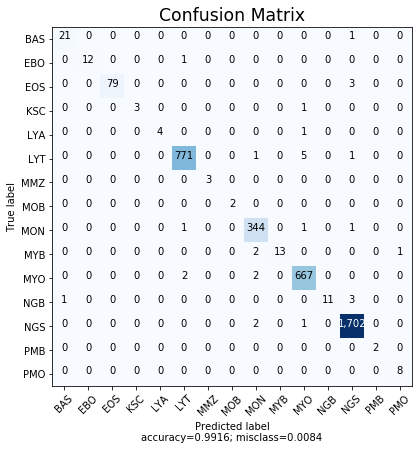

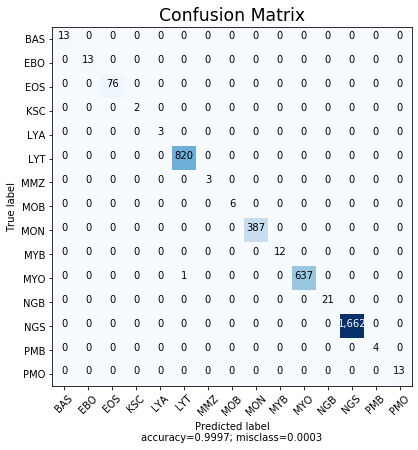

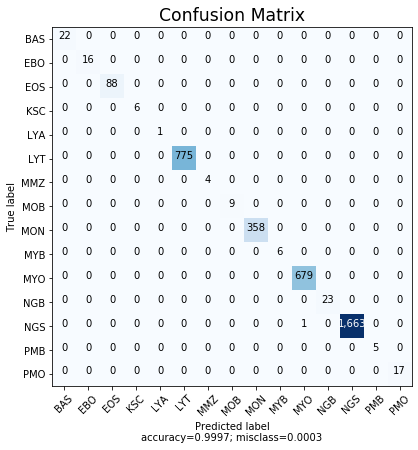

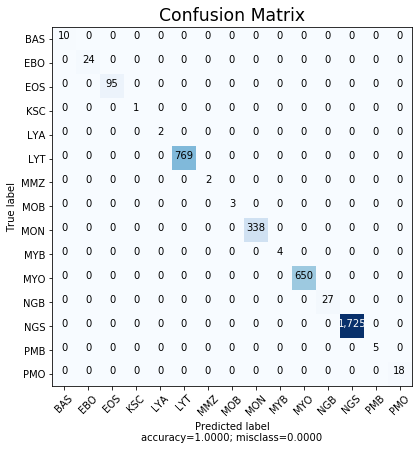

In [32]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(0,5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['BAS', 'EBO', 'EOS','KSC','LYA','LYT','MMZ','MOB','MON','MYB','MYO','NGB','NGS','PMB','PMO'],
                      title  = "Confusion Matrix")

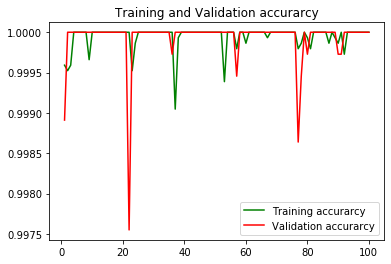

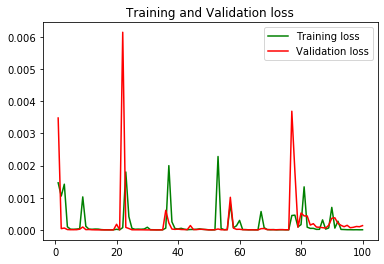

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import accuracy_score,classification_report 
target_names = ['BAS', 'EBO', 'EOS','KSC','LYA','LYT','MMZ','MOB','MON','MYB','MYO','NGB','NGS','PMB','PMO']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))

              precision    recall  f1-score   support

         BAS       1.00      1.00      1.00        10
         EBO       1.00      1.00      1.00        24
         EOS       1.00      1.00      1.00        95
         KSC       1.00      1.00      1.00         1
         LYA       1.00      1.00      1.00         2
         LYT       1.00      1.00      1.00       769
         MMZ       1.00      1.00      1.00         2
         MOB       1.00      1.00      1.00         3
         MON       1.00      1.00      1.00       338
         MYB       1.00      1.00      1.00         4
         MYO       1.00      1.00      1.00       650
         NGB       1.00      1.00      1.00        27
         NGS       1.00      1.00      1.00      1725
         PMB       1.00      1.00      1.00         5
         PMO       1.00      1.00      1.00        18

    accuracy                           1.00      3673
   macro avg       1.00      1.00      1.00      3673
weighted avg       1.00   

In [35]:
class_to_label_map={ 0 : 'BAS', 1 :'EBO', 2:'EOS',3:'KSC',4:'LYA',5:'LYT',6:'MMZ',7:'MOB',8:'MON',9:'MYB',10:'MYO',11:'NGB',12:'NGS',13:'PMB',14:'PMO'}

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


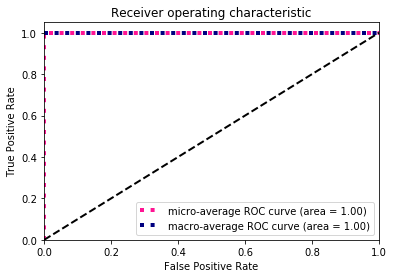

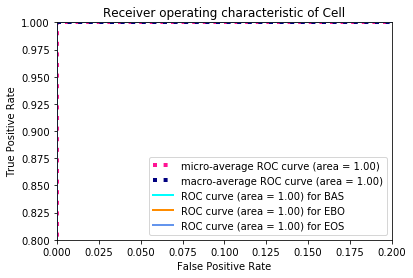

In [36]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =15

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()


In [38]:
model.save("model_cancer_single_new.h5")